<img src="logo.png" alt="University of Illinois" style="width: 200px;"/>

### Seasonal Error Analysis (all seasons) ###
by: Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2019 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

### Explanation###
This code plots error analysis for Manhattan Traffic Data

imports

In [1]:
import pandas
import numpy
import matplotlib.pylab as plt
%matplotlib inline
import scipy.interpolate
import scipy.optimize 

In [2]:
def saver(fname):
    plt.savefig(fname+".pdf",bbox_inches="tight")
    
params={
    #"font.size":20,
    "figure.titlesize":"large",
    "lines.linewidth":3,
    #"legend.fontsize":"small",
    #"xtick.labelsize":"x-small",
    #"ytick.labelsize":"x-small",
    #"axes.labelsize": 'small',
}
plt.rcParams.update(params) 

constants

In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Provide number of curves and the desired colormap https://matplotlib.org/tutorials/colors/colormaps.html
n_curves = 6
colormap = plt.get_cmap('plasma')# Old colormap: 'YlOrRd' 

cNorm  = colors.Normalize(vmin=0, vmax=n_curves-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

colorsequence=[]
for i in range(n_curves):
    colorsequence.append(scalarMap.to_rgba(i))

# colorsequence=['b', 'g', 'r', 'c', 'm', 'y', 'k']
stylesequence=["-",":","--","-.","-"]

In [4]:
class processor:
    def __init__(self,df):
        self.rank_vals=pandas.unique(df.index.get_level_values("rank"))
        self.df=df.dropna(axis="index")
        
    def by_penalty(self,rank):
        temp=self.df.groupby(by="rank").get_group(rank)
        return temp.reset_index(level="rank",drop=True)
    
    def sparsity_by_penalty(self,rank):
        temp=self.by_penalty(rank)["sparsity"]
        return temp
    
    def error_by_sparsity(self,rank):
        temp=self.by_penalty(rank)
        temp=temp.set_index(keys="sparsity",drop=True)["error"]
        temp.sort_index(axis="index",inplace=True)
        return temp

In [5]:
class monotone_invert:
    def __init__(self,df,sign="increasing"):
        self.df=df
        self.tvals=numpy.array(self.df.index)
        self.yvals=numpy.array(self.df.to_numpy())
        if len(self.df)<2:
            return None
        self.N=len(self.df)
        self.L=numpy.tril(numpy.ones(shape=(self.N,self.N)),k=0)
        self.ctr=1
        x0=[numpy.mean(self.yvals)/self.N]*self.N
        
        def objective(d):
            error=self.yvals-self.L.dot(d)
            return 0.5*error.dot(error)
        
        def jacobian(self,d): #not used
            error=self.yvals-self.L.dot(d)
            return self.L.T.dot(error)
        
        def hessian(self,d): # not used
            return self.L.T*dot(self.L)
        
        print(self.N)
        pm=1
        if (sign=="decreasing"):
            pm=-1
        constraints={"type":"ineq","fun":lambda x:pm*x}
        res=scipy.optimize.minimize(objective,x0=x0,method="COBYLA",constraints=constraints)
        print(res)
        d_best=res.x
        self.y_approx_vals=self.L.dot(d_best)
        print("y_approx",self.y_approx_vals)
        
        self.linapprox=scipy.interpolate.interp1d(self.tvals,self.y_approx_vals,copy=True,bounds_error=True)
        
    def inc_approx(self,t):
        if not (min(self.tvals)<=t<=max(self.tvals)):
            return numpy.nan
        return self.linapprox(t).item()

        
        tval=scipy.optimize.brentq(lambda x:self.linapprox(x)-yval,min(self.tvals),max(self.tvals))
        return tval

In [6]:
#fname="LevelCurveData2"
fname="seasonal_values_preAxing"

read data

In [7]:
data_raw=pandas.read_csv(fname+".csv",na_values=['nan',' nan'])
print(data_raw.head())

   Rank  Beta  Error_fall  Error_winter  Error_spring  Error_summer  \
0    40     0   27.410104     25.849315     26.234512     27.003513   
1    40  1000   27.733881     26.193886     26.553121     27.298732   
2    40  2000   27.722486     26.217714     26.543215     27.279285   
3    40  3000   27.758684     26.272056     26.576124     27.308640   
4    40  4000   27.807777     26.331955     26.621324     27.350757   

   Error_total  Sparsity  
0    26.638031  0.675348  
1    26.958008  0.694921  
2    26.952959  0.716475  
3    26.990673  0.730274  
4    27.039437  0.740969  


In [8]:
data=data_raw.copy()
data.columns=[colname.strip().lower() for colname in data.columns]
data=data.dropna(axis='index',subset=["rank","beta"])
data["rank"]=data["rank"].astype('int')
data=data.set_index(keys=["rank","beta"])
print(data.head())
print(data.columns)

           error_fall  error_winter  error_spring  error_summer  error_total  \
rank beta                                                                      
40   0      27.410104     25.849315     26.234512     27.003513    26.638031   
     1000   27.733881     26.193886     26.553121     27.298732    26.958008   
     2000   27.722486     26.217714     26.543215     27.279285    26.952959   
     3000   27.758684     26.272056     26.576124     27.308640    26.990673   
     4000   27.807777     26.331955     26.621324     27.350757    27.039437   

           sparsity  
rank beta            
40   0     0.675348  
     1000  0.694921  
     2000  0.716475  
     3000  0.730274  
     4000  0.740969  
Index(['error_fall', 'error_winter', 'error_spring', 'error_summer',
       'error_total', 'sparsity'],
      dtype='object')


In [9]:
dataDict={"fall":None,"winter":None,"spring":None,"summer":None,"total":None}
for season in dataDict.keys():
    print("---")
    print(season)
    data_season=data[["error_"+season,"sparsity"]]
    data_season=data_season.rename(mapper={"error_"+season:"error"},axis="columns")
    print(data_season.head())
    dataDict[season]=data_season

---
fall
               error  sparsity
rank beta                     
40   0     27.410104  0.675348
     1000  27.733881  0.694921
     2000  27.722486  0.716475
     3000  27.758684  0.730274
     4000  27.807777  0.740969
---
winter
               error  sparsity
rank beta                     
40   0     25.849315  0.675348
     1000  26.193886  0.694921
     2000  26.217714  0.716475
     3000  26.272056  0.730274
     4000  26.331955  0.740969
---
spring
               error  sparsity
rank beta                     
40   0     26.234512  0.675348
     1000  26.553121  0.694921
     2000  26.543215  0.716475
     3000  26.576124  0.730274
     4000  26.621324  0.740969
---
summer
               error  sparsity
rank beta                     
40   0     27.003513  0.675348
     1000  27.298732  0.694921
     2000  27.279285  0.716475
     3000  27.308640  0.730274
     4000  27.350757  0.740969
---
total
               error  sparsity
rank beta                     
40   0     26.6380

In [10]:
pDict={season:processor(dataDict[season]) for season in dataDict.keys()}

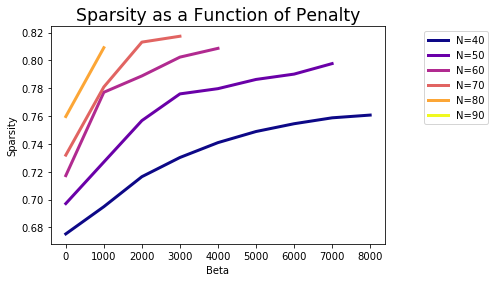

In [36]:
plt.figure()
for n,rank in enumerate(pDict["total"].rank_vals):
    df=pDict["total"].sparsity_by_penalty(rank)
    plt.plot(df.index,df.values,label="N={:}".format(rank),color=colorsequence[n])
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel("Beta")
plt.ylabel("Sparsity")
plt.title("Sparsity as a Function of Penalty",fontsize="xx-large")
plt.savefig("sparsity_as_penalty.pdf", bbox_inches='tight')
plt.show()
plt.close()

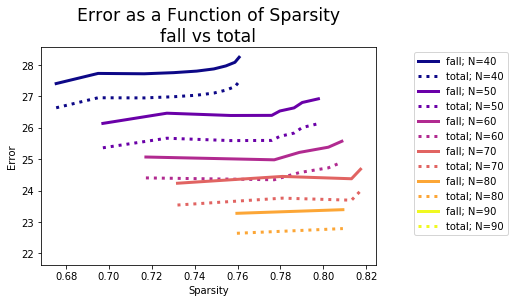

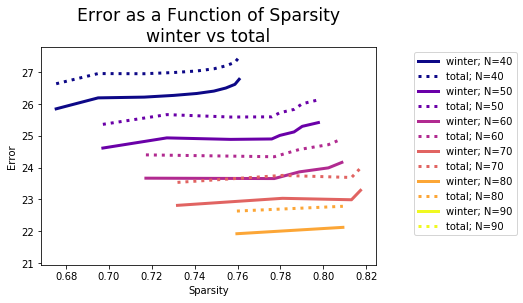

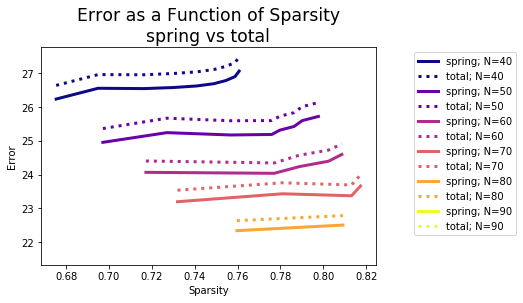

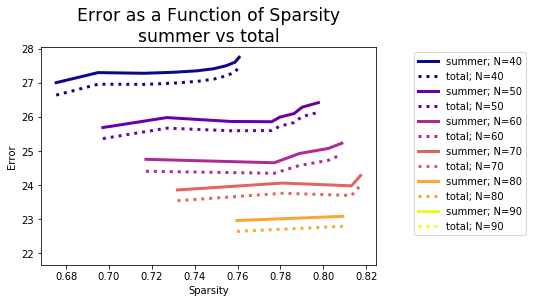

In [37]:
for season in dataDict.keys():
    if (season=="total"):
        continue
    plt.figure()
    for nn,rank in enumerate(pDict[season].rank_vals):
        df=pDict[season].error_by_sparsity(rank)
        plt.plot(df.index,df.values,label=season+"; N={:}".format(rank),color=colorsequence[nn],linestyle=stylesequence[0])
        df=pDict["total"].error_by_sparsity(rank)
        plt.plot(df.index,df.values,label="total"+"; N={:}".format(rank),color=colorsequence[nn],linestyle=stylesequence[1])
        
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.xlabel("Sparsity")
    plt.ylabel("Error")
    title=[]
    title.append("Error as a Function of Sparsity")
    title.append(season+" vs total")
    plt.title("\n".join(title),fontsize="xx-large")
    plt.savefig("error_by_sparsity_"+season+".pdf", bbox_inches='tight')
    plt.show()
    plt.close()

In [11]:
fDict={}
for season in dataDict.keys():
    fDict[season]={rank:monotone_invert(pDict[season].error_by_sparsity(rank)) for rank in pDict[season].rank_vals}

9
     fun: 3.557994538382365e-05
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 820
  status: 1
 success: True
       x: array([2.74092449e+01, 3.19605832e-01, 5.55111512e-21, 2.89575606e-02,
       5.11691481e-02, 6.73842449e-02, 9.74084448e-02, 1.14810548e-01,
       1.61583670e-01])
y_approx [27.40924488 27.72885072 27.72885072 27.75780828 27.80897743 27.87636167
 27.97377011 28.08858066 28.25016433]
8
     fun: 0.0016825198606674966
   maxcv: 6.359344432698223e-20
 message: 'Optimization terminated successfully.'
    nfev: 588
  status: 1
 success: True
       x: array([ 2.61396567e+01,  2.78512483e-01, -6.28995549e-20, -6.35934443e-20,
        1.16874777e-01,  1.00083057e-01,  1.71017004e-01,  1.18503190e-01])
y_approx [26.13965669 26.41816917 26.41816917 26.41816917 26.53504395 26.635127
 26.80614401 26.9246472 ]
5
     fun: 0.0019904006097383495
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 292
  status: 1
 success: True
  

In [12]:
sparsityvals=numpy.linspace(start=0.68,stop=0.83,num=5)
print(sparsityvals)

[0.68   0.7175 0.755  0.7925 0.83  ]


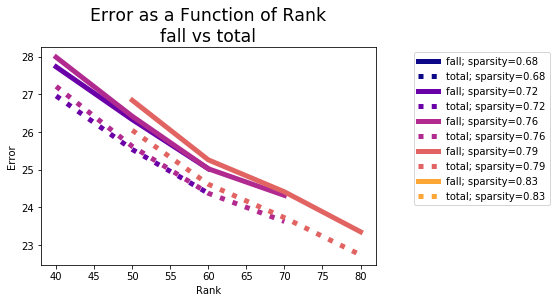

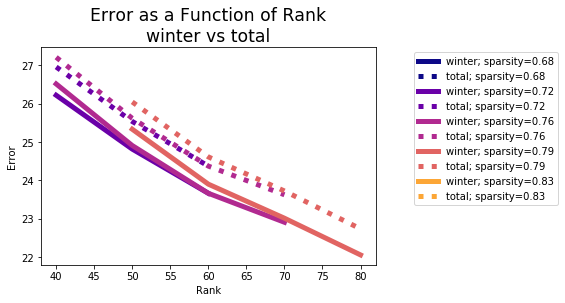

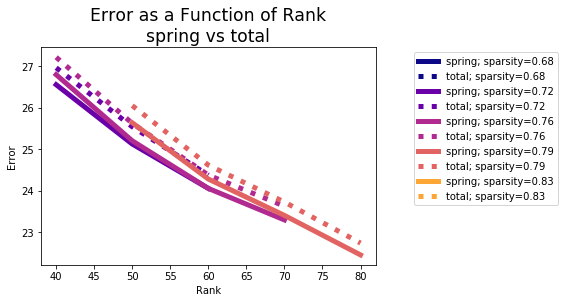

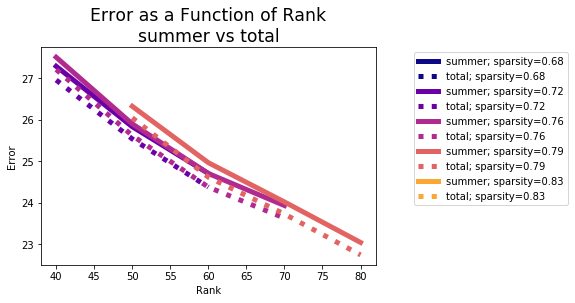

In [14]:
for season in dataDict.keys():
    if (season=="total"):
        continue
    plt.figure()
    for nn,sparsity in enumerate(sparsityvals):
        errvals=[fDict[season][rank].inc_approx(sparsity)  for rank in pDict[season].rank_vals]
        plt.plot(pDict[season].rank_vals,errvals,linewidth=5,label=season+"; sparsity={:.2f}".format(sparsity),color=colorsequence[nn],
                linestyle=stylesequence[0])
        errvals=[fDict["total"][rank].inc_approx(sparsity)  for rank in pDict["total"].rank_vals]
        plt.plot(pDict[season].rank_vals,errvals,linewidth=5,label="total"+"; sparsity={:.2f}".format(sparsity),color=colorsequence[nn],
                linestyle=stylesequence[1])
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.xlabel("Rank")
    plt.ylabel("Error")
    title=[]
    title.append("Error as a Function of Rank")
    title.append(season+" vs total")
    plt.title("\n".join(title),fontsize="xx-large")
    plt.savefig("error_by_rank_"+season+".pdf", bbox_inches='tight')
    plt.show()
    plt.close()